In [1]:
import matplotlib.pyplot as plt
import keras
import numpy as np
import glob
import os
from PIL import Image
import tqdm
%matplotlib inline
np.__version__, keras.__version__

Using TensorFlow backend.


('1.13.1', '2.0.6')

In [2]:
IMG_DIR = "./train/"
IM_WIDTH = 128
IM_HEIGHT = 128

In [3]:
def read_images(directory, resize_to=(128, 128)):
    """
    Reads images and labels from the given directory
    :param directory directory from which to read the files
    :param resize_to a tuple of width, height to resize the images
    : returns a tuple of list of images and labels
    """
    files = glob.glob(directory + "*.jpg")
    images = []
    labels = []
    for f in tqdm.tqdm_notebook(files):
        im = Image.open(f)
        im = im.resize(resize_to)
        im = np.array(im) / 255.0
        im = im.astype("float32")
        images.append(im)
        
        label = 1 if "dog" in f.lower() else 0
        labels.append(label)
        
    return np.array(images), np.array(labels)

In [4]:
if os.path.exists("./data.npy") and os.path.exists("./labels.npy"):
    X = np.load("./data.npy")
    y = np.load("./labels.npy")
else:
    X, y = read_images(directory=IMG_DIR, resize_to=(IM_WIDTH, IM_HEIGHT))
    np.save("./data.npy", X)
    np.save("./labels.npy", y)
# make sure we have 25000 images
assert len(X) == len(y) == 25000

In [5]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
del X
del y

In [6]:
X_train.shape, X_test.shape

((17500, 128, 128, 3), (7500, 128, 128, 3))

In [7]:
def plot_images(images, labels):
    n_cols = min(5, len(images))
    n_rows = len(images) // n_cols
    fig = plt.figure(figsize=(8, 8))

    for i in range(n_rows * n_cols):
        sp = fig.add_subplot(n_rows, n_cols, i+1)
        plt.axis("off")
        plt.imshow(images[i])
        sp.set_title(labels[i])
    plt.show()
    
def humanize_labels(labels):
    """
    Converts numeric labels to human friendly string labels
    :param labels numpy array of int
    :returns numpy array of human friendly labels
    """
    return np.where(labels == 1, "dog", "cat")

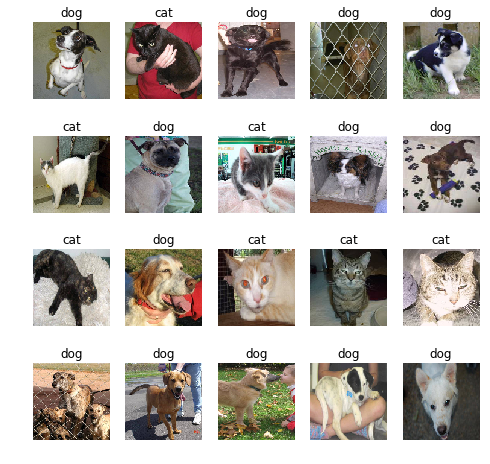

In [8]:
plot_images(X_train[:20], humanize_labels(y_train[:20]))

# Prepare model

Create a base model using VGG16 architecture. We discard the fully connected layer of VGG by specifying include_top=False since the VGG16 model is trained on ImageNet dataset that has 10,000 categories but we only want to predict one of two categories (cat or dog).

In [16]:
from keras.applications import VGG16
from keras.layers import Dense, Flatten, Activation, BatchNormalization
from keras.models import Model
from keras.optimizers import SGD

base_model = VGG16(include_top=False, input_shape=(IM_HEIGHT, IM_WIDTH, 3))
# we should set all the layers of base model as non-trainable
# since this model is already trained, we don't want to do it again
for layer in base_model.layers:
    layer.trainable = False

# we take the output of the base model and flatten it into 1D vector
_ = Flatten()(base_model.output)

# we could add more dense layers here as shown below
# but for this demonstration we'll directly make final Dense layer
# _ = Dense(128)(_)
# _ = Activation("relu")(_)
# _ = BatchNormalization()(_)

_ = Dense(1)(_)
_ = Activation("sigmoid")(_)
# build our model in which the input to the model is whatever the
# input was to the base_model
model = Model(inputs=base_model.inputs, outputs=_)

sgd = SGD(lr=0.001, momentum=0.9)
model.compile(optimizer=sgd, loss="binary_crossentropy", metrics=["accuracy"])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0         
__________

In [27]:
model.fit(X_train, y_train, batch_size=64, epochs=2)

Epoch 1/2


ResourceExhaustedError: OOM when allocating tensor with shape[64,128,128,64]
	 [[Node: block1_conv1_4/convolution = Conv2D[T=DT_FLOAT, data_format="NHWC", padding="SAME", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/gpu:0"](_recv_input_5_0/_529, block1_conv1_4/kernel/read)]]
	 [[Node: mul_3/_563 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/cpu:0", send_device="/job:localhost/replica:0/task:0/gpu:0", send_device_incarnation=1, tensor_name="edge_537_mul_3", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/cpu:0"]()]]

Caused by op 'block1_conv1_4/convolution', defined at:
  File "C:\Users\Sanjaya\Anaconda3\lib\runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\Sanjaya\Anaconda3\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\Sanjaya\Anaconda3\lib\site-packages\ipykernel\__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "C:\Users\Sanjaya\Anaconda3\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "C:\Users\Sanjaya\Anaconda3\lib\site-packages\ipykernel\kernelapp.py", line 403, in start
    ioloop.IOLoop.instance().start()
  File "C:\Users\Sanjaya\Anaconda3\lib\site-packages\zmq\eventloop\ioloop.py", line 151, in start
    super(ZMQIOLoop, self).start()
  File "C:\Users\Sanjaya\Anaconda3\lib\site-packages\tornado\ioloop.py", line 883, in start
    handler_func(fd_obj, events)
  File "C:\Users\Sanjaya\Anaconda3\lib\site-packages\tornado\stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\Users\Sanjaya\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py", line 433, in _handle_events
    self._handle_recv()
  File "C:\Users\Sanjaya\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py", line 465, in _handle_recv
    self._run_callback(callback, msg)
  File "C:\Users\Sanjaya\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py", line 407, in _run_callback
    callback(*args, **kwargs)
  File "C:\Users\Sanjaya\Anaconda3\lib\site-packages\tornado\stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\Users\Sanjaya\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 260, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "C:\Users\Sanjaya\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 212, in dispatch_shell
    handler(stream, idents, msg)
  File "C:\Users\Sanjaya\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 370, in execute_request
    user_expressions, allow_stdin)
  File "C:\Users\Sanjaya\Anaconda3\lib\site-packages\ipykernel\ipkernel.py", line 175, in do_execute
    shell.run_cell(code, store_history=store_history, silent=silent)
  File "C:\Users\Sanjaya\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2902, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "C:\Users\Sanjaya\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3006, in run_ast_nodes
    if self.run_code(code, result):
  File "C:\Users\Sanjaya\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3066, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-16-8109e0468f54>", line 6, in <module>
    base_model = VGG16(include_top=False, input_shape=(IM_HEIGHT, IM_WIDTH, 3))
  File "C:\Users\Sanjaya\Anaconda3\lib\site-packages\keras\applications\vgg16.py", line 111, in VGG16
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1')(img_input)
  File "C:\Users\Sanjaya\Anaconda3\lib\site-packages\keras\engine\topology.py", line 596, in __call__
    output = self.call(inputs, **kwargs)
  File "C:\Users\Sanjaya\Anaconda3\lib\site-packages\keras\layers\convolutional.py", line 164, in call
    dilation_rate=self.dilation_rate)
  File "C:\Users\Sanjaya\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py", line 3156, in conv2d
    data_format='NHWC')
  File "C:\Users\Sanjaya\Anaconda3\lib\site-packages\tensorflow\python\ops\nn_ops.py", line 661, in convolution
    op=op)
  File "C:\Users\Sanjaya\Anaconda3\lib\site-packages\tensorflow\python\ops\nn_ops.py", line 331, in with_space_to_batch
    return op(input, num_spatial_dims, padding)
  File "C:\Users\Sanjaya\Anaconda3\lib\site-packages\tensorflow\python\ops\nn_ops.py", line 653, in op
    name=name)
  File "C:\Users\Sanjaya\Anaconda3\lib\site-packages\tensorflow\python\ops\nn_ops.py", line 129, in _non_atrous_convolution
    name=name)
  File "C:\Users\Sanjaya\Anaconda3\lib\site-packages\tensorflow\python\ops\gen_nn_ops.py", line 403, in conv2d
    data_format=data_format, name=name)
  File "C:\Users\Sanjaya\Anaconda3\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 768, in apply_op
    op_def=op_def)
  File "C:\Users\Sanjaya\Anaconda3\lib\site-packages\tensorflow\python\framework\ops.py", line 2336, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "C:\Users\Sanjaya\Anaconda3\lib\site-packages\tensorflow\python\framework\ops.py", line 1228, in __init__
    self._traceback = _extract_stack()

ResourceExhaustedError (see above for traceback): OOM when allocating tensor with shape[64,128,128,64]
	 [[Node: block1_conv1_4/convolution = Conv2D[T=DT_FLOAT, data_format="NHWC", padding="SAME", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/gpu:0"](_recv_input_5_0/_529, block1_conv1_4/kernel/read)]]
	 [[Node: mul_3/_563 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/cpu:0", send_device="/job:localhost/replica:0/task:0/gpu:0", send_device_incarnation=1, tensor_name="edge_537_mul_3", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/cpu:0"]()]]


In [22]:
print(model.metrics_names)
model.evaluate(X_test, y_test, batch_size=64, verbose=0)

['loss', 'acc']


[0.27261228160858153, 0.88226666673024501]

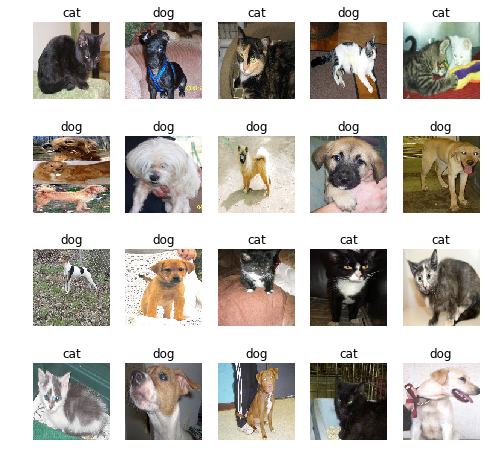

In [23]:
predictions = model.predict(X_test)
predictions = np.where(predictions.flatten() > 0.5, 1, 0)
# plot random 20
p = np.random.permutation(len(predictions))
plot_images(X_test[p[:20]], humanize_labels(predictions[p[:20]]))